In [1]:
import os
import pandas as pd
import numpy as np
import glob
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
gtf_file = "/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/refs/hg38/gencode.v38.annotation.gtf"  # Replace with your GTF file path
fasta_file = "/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/refs/hg38/GRCh38.p13.genome.fa"

In [3]:
from Bio import SeqIO

def extract_sequences(fasta_file, df):
    # Load the genome sequence
    genome = SeqIO.to_dict(SeqIO.parse(fasta_file, "fasta"))

    # Extract sequences
    sequences = {}
    for _, row in df.iterrows():
        seqname = row[0]
        start = row[3]
        end = row[4]
        sequence = genome[seqname].seq[start-1:end]  # Adjust for 0-based indexing
        sequences[row['key']] = str(sequence)

    return sequences

In [4]:
def assign_utr(x):
    strand = x[6]
    utr_start = x[3]
    utr_end = x[4]
    if strand =='+':
        if utr_end < gtf_CDS_start[x['transcript_id']]:
            return '5UTR'
        elif utr_start > gtf_CDS_end[x['transcript_id']]:
            return '3UTR'

    if strand =='-':
        if utr_start > gtf_CDS_end[x['transcript_id']]:
            return '5UTR'
        elif utr_end <  gtf_CDS_start[x['transcript_id']]:
            return '3UTR'

### Preparing Isoform Features

In [5]:
gencode_transcripts = pd.read_csv(gtf_file, sep='\t', comment='#', header=None)
gencode_transcripts['transcript_id'] = gencode_transcripts[8].str.extract('transcript_id "([^"]+)"')
gencode_transcripts['gene_id'] = gencode_transcripts[8].str.extract('gene_id "([^"]+)"')

In [6]:
CDS = gencode_transcripts[gencode_transcripts[2]=='CDS']
gtf_CDS_start = dict(zip(CDS['transcript_id'], CDS[3]))
gtf_CDS_end = dict(zip(CDS['transcript_id'], CDS[4]))

In [7]:
UTR = gencode_transcripts[gencode_transcripts[2]=='UTR']
UTR[2] = UTR.apply(assign_utr, axis=1)

/tmp/ipykernel_1453272/3028768742.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  UTR[2] = UTR.apply(assign_utr, axis=1)


In [8]:
five_UTR = UTR[UTR[2]=='5UTR']
three_UTR = UTR[UTR[2]=='3UTR']
five_UTR['key'] = five_UTR.apply(lambda x: f"{x['transcript_id']}:{x[0]}:{x[3]}:{x[4]}", axis=1)
three_UTR['key'] = three_UTR.apply(lambda x: f"{x['transcript_id']}:{x[0]}:{x[3]}:{x[4]}", axis=1)

/tmp/ipykernel_1453272/142618749.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  five_UTR['key'] = five_UTR.apply(lambda x: f"{x['transcript_id']}:{x[0]}:{x[3]}:{x[4]}", axis=1)
/tmp/ipykernel_1453272/142618749.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  three_UTR['key'] = three_UTR.apply(lambda x: f"{x['transcript_id']}:{x[0]}:{x[3]}:{x[4]}", axis=1)


In [9]:
five_UTR['length'] = five_UTR[4] - five_UTR[3]
three_UTR['length'] = three_UTR[4] - three_UTR[3]

/tmp/ipykernel_1453272/3584739827.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  five_UTR['length'] = five_UTR[4] - five_UTR[3]
/tmp/ipykernel_1453272/3584739827.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  three_UTR['length'] = three_UTR[4] - three_UTR[3]


In [10]:
five_UTR_seq_dict = extract_sequences(fasta_file, five_UTR)
three_UTR_seq_dict = extract_sequences(fasta_file, three_UTR)

In [11]:
five_UTR['sequence'] = five_UTR.key.map(five_UTR_seq_dict)
three_UTR['sequence'] = three_UTR.key.map(three_UTR_seq_dict)

/tmp/ipykernel_1453272/1217000308.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  five_UTR['sequence'] = five_UTR.key.map(five_UTR_seq_dict)
/tmp/ipykernel_1453272/1217000308.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  three_UTR['sequence'] = three_UTR.key.map(three_UTR_seq_dict)


In [12]:
def get_rc(seq):
    '''get the reverse complement sequence'''
    nuc_dict = {"A":"T", "T":"A", "C":"G", "G":"C"}
    return ''.join([nuc_dict[n] for n in seq[::-1]])

In [13]:
def account_for_strand(df):
    '''get the reverse complement if the strand is negative'''
    if df[6] == '+' :
        return df['sequence']
    elif df[6] =='-':
        return get_rc(df['sequence'])

In [14]:
five_UTR['strand_aware_sequence'] = five_UTR.apply(account_for_strand, axis=1)

/tmp/ipykernel_1453272/56296753.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  five_UTR['strand_aware_sequence'] = five_UTR.apply(account_for_strand, axis=1)


In [15]:
five_UTR_strand_aware_sequence_dict = dict(zip(five_UTR.transcript_id, five_UTR.strand_aware_sequence))

In [16]:
three_UTR['strand_aware_sequence'] = three_UTR.apply(account_for_strand, axis=1)

/tmp/ipykernel_1453272/487845849.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  three_UTR['strand_aware_sequence'] = three_UTR.apply(account_for_strand, axis=1)


In [17]:
three_UTR_strand_aware_sequence_dict = dict(zip(three_UTR.transcript_id, three_UTR.strand_aware_sequence))

In [19]:
transcript_df = pd.read_csv('/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/notebooks/231_data/annotated_transcript_editsC_copy_jan2024.txt', sep='\t', index_col=0)

In [21]:
from scipy import stats

In [22]:
transcript_df['ttest_pval'] = transcript_df.apply(lambda x: stats.ttest_ind([x['editsC_NT_rep1'], x['editsC_NT_rep1']], [x['editsC_COCL2_rep1'], x['editsC_COCL2_rep2']])[1], axis=1)

/tscc/projects/ps-yeolab4/software/miniconda_tscc2/envs/python3essential-1.99.0/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates, boxplot
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [24]:
transcript_df['fiveUTR_seq']=transcript_df.index.map(five_UTR_strand_aware_sequence_dict)
transcript_df['threeUTR_seq']=transcript_df.index.map(three_UTR_strand_aware_sequence_dict)

In [25]:
transcript_df.replace([np.inf, -np.inf], np.nan, inplace=True)
transcript_df.dropna(inplace=True)

/tscc/projects/ps-yeolab4/software/miniconda_tscc2/envs/python3essential-1.99.0/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/tscc/projects/ps-yeolab4/software/miniconda_tscc2/envs/python3essential-1.99.0/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/tmp/ipykernel_1453272/546354891.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transcript_df_for_editsC_rpkm_cluster['editsC_rpkm_Cluster'] = clusters_editsC_rpkm


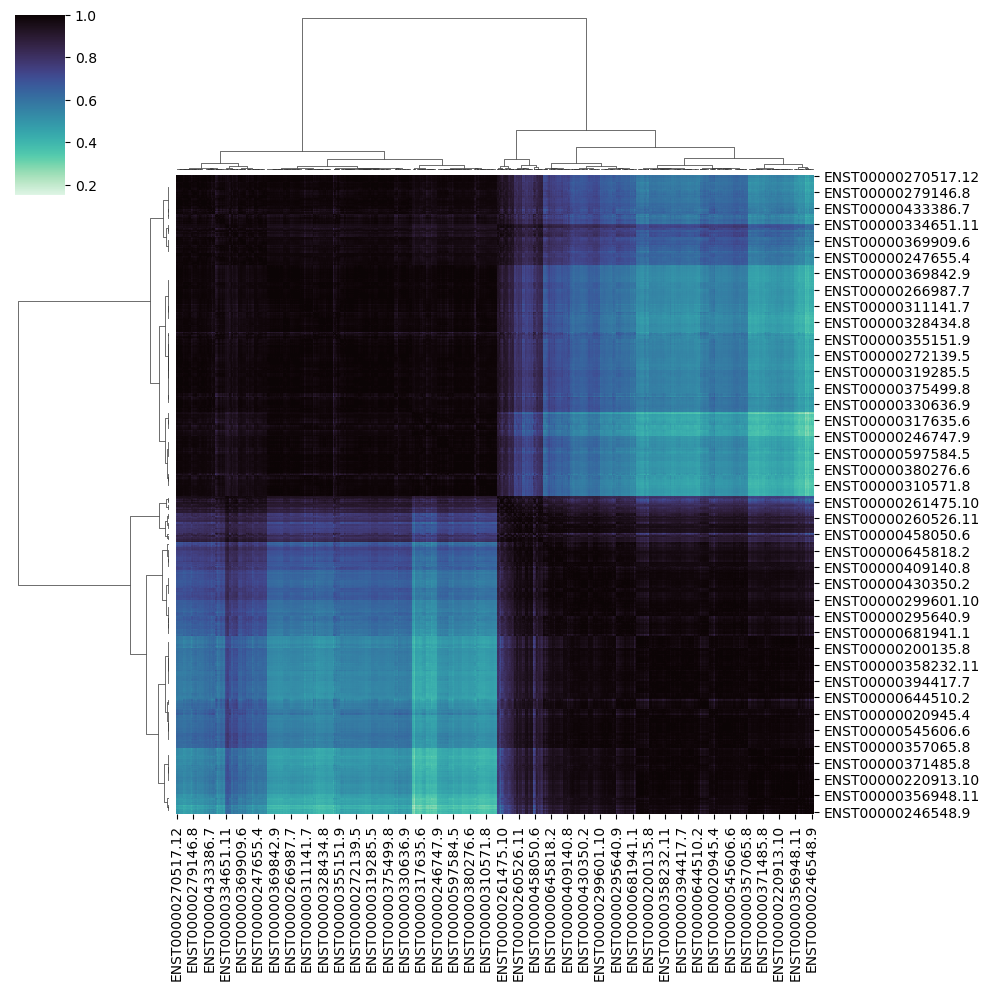

In [26]:
# Generate all-zero mask
editsC_rpkm_corr = transcript_df[((transcript_df['ttest_pval'] <=0.05) & (np.abs(transcript_df['edit_logFC']) >=1)) | ((transcript_df['padj'] <=0.05) & (np.abs(transcript_df['log2FoldChange']) >=1))][['editsC_NT_rep1', 'editsC_NT_rep2', 'editsC_COCL2_rep1','editsC_COCL2_rep2','231_NT_rep1_RPKM', '231_NT_rep2_RPKM', '231_cocl2_rep1_RPKM','231_cocl2_rep2_RPKM']].T.corr()
editsC_rpkm_cluster = sns.clustermap(editsC_rpkm_corr, cmap='mako_r', method='ward')
row_linkage_editsC_rpkm = editsC_rpkm_cluster.dendrogram_row.linkage
num_clusters_editsC_rpkm = 5
clusters_editsC_rpkm = fcluster(row_linkage_editsC_rpkm, num_clusters_editsC_rpkm, criterion='maxclust')
transcript_df_for_editsC_rpkm_cluster = transcript_df[((transcript_df['ttest_pval'] <=0.05) & (np.abs(transcript_df['edit_logFC']) >=1)) | ((transcript_df['padj'] <=0.05) & (np.abs(transcript_df['log2FoldChange']) >=1))]
transcript_df_for_editsC_rpkm_cluster['editsC_rpkm_Cluster'] = clusters_editsC_rpkm


In [27]:
cluster_group_genes = {}
cluster_group_transcripts = {}
for i in range(num_clusters_editsC_rpkm):
    cluster_group_genes[i+1] = set(transcript_df_for_editsC_rpkm_cluster[transcript_df_for_editsC_rpkm_cluster['editsC_rpkm_Cluster']==(i+1)]['gene_name'].tolist())
    cluster_group_transcripts[i+1] = set(transcript_df_for_editsC_rpkm_cluster[transcript_df_for_editsC_rpkm_cluster['editsC_rpkm_Cluster']==(i+1)].index.tolist())

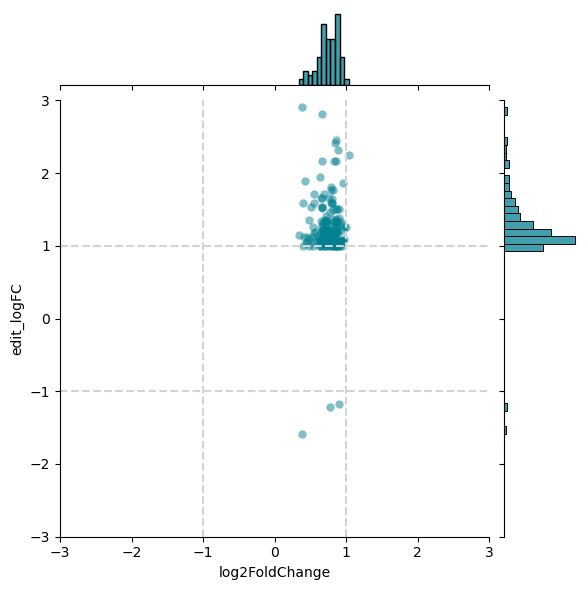

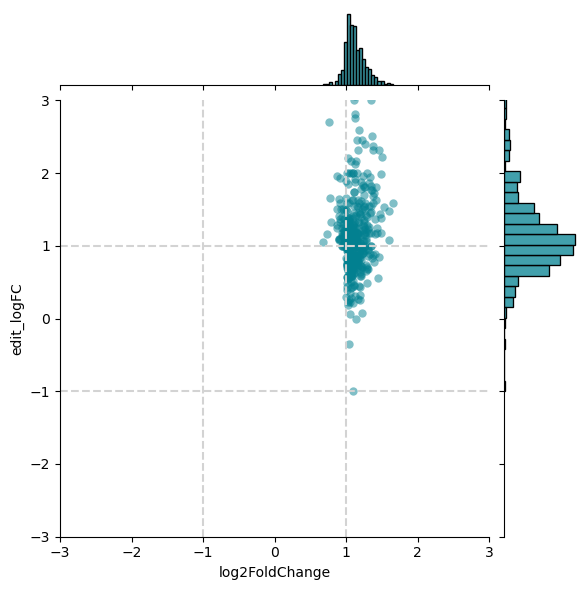

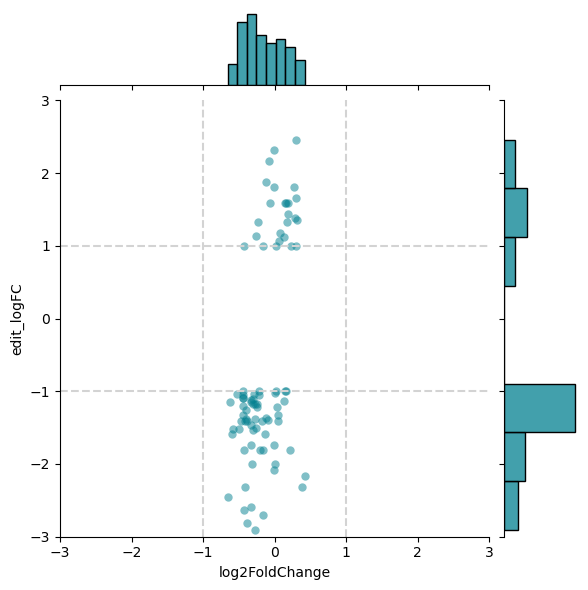

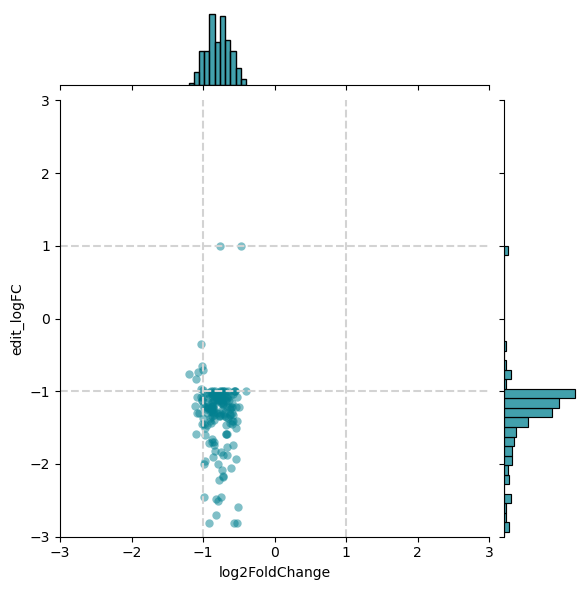

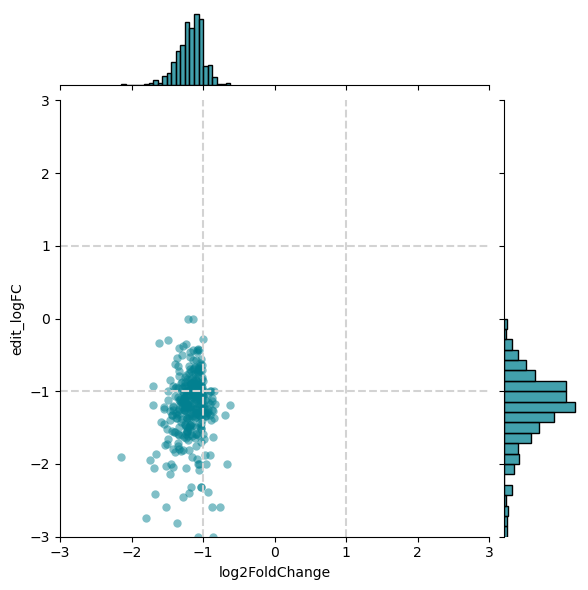

In [28]:
for i in range(num_clusters_editsC_rpkm):
    sns.jointplot(data=transcript_df_for_editsC_rpkm_cluster[transcript_df_for_editsC_rpkm_cluster['editsC_rpkm_Cluster']==(i+1)], y='edit_logFC', x='log2FoldChange',linewidth=0, alpha=0.5, color='#028090')
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    plt.axvline(-1, linestyle='dashed', color='lightgrey')
    plt.axvline(1, linestyle='dashed', color='lightgrey')
    plt.axhline(-1, linestyle='dashed', color='lightgrey')
    plt.axhline(1, linestyle='dashed', color='lightgrey')
    

In [29]:
lut = dict(zip([i+1 for i in range(num_clusters_editsC_rpkm)],sns.hls_palette(num_clusters_editsC_rpkm)))

In [30]:
row_colors= transcript_df_for_editsC_rpkm_cluster['editsC_rpkm_Cluster'].map(lut)

In [32]:
fig_path = '/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/notebooks/figs/'

/tscc/projects/ps-yeolab4/software/miniconda_tscc2/envs/python3essential-1.99.0/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/tscc/projects/ps-yeolab4/software/miniconda_tscc2/envs/python3essential-1.99.0/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


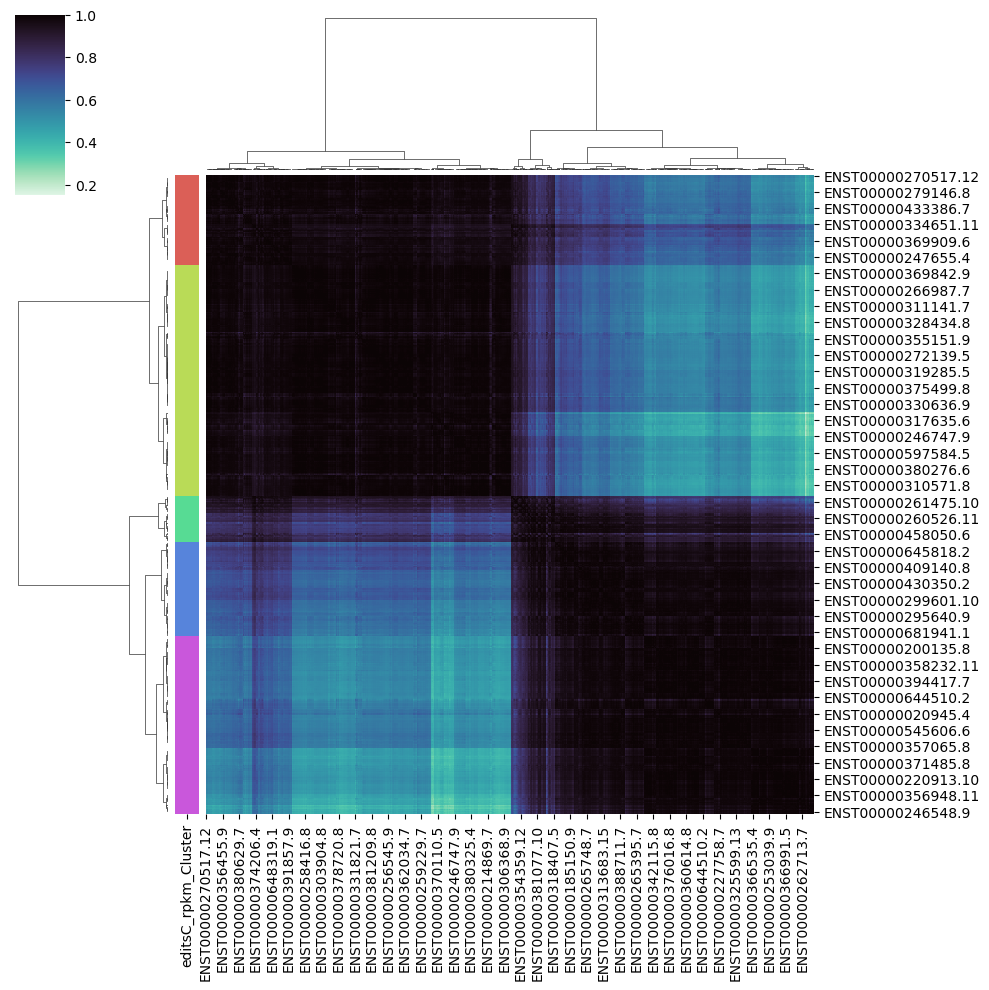

In [33]:
sns.clustermap(editsC_rpkm_corr, cmap='mako_r', method='ward', row_colors=row_colors)